[-1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.11022302e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00]
[14.68475666497896, 13.16530065540698, 12.080846367841557, 11.251297403874508, 10.5874838068021, 10.039135624742237, 9.575311858275528, 9.175714609986938, 8.826365392875314, 8.517261782755408, 8.241020905778406, 7.9920517148331225, 7.766027658716175, 7.559538389810107, 7.369852582704295, 7.194752112124567, 7.03241342325875, 6.881320964220536, 6.740202876820141, 6.60798243948423, 6.483740906794028, 6.3666886862882395, 6.25614272323603, 6.151508569623317, 6.052266027807181]
[252.38627500490676, 210.78763153042942, 183.34808934789453, 163.6393870475814, 148.67013109498083, 136.84135769212

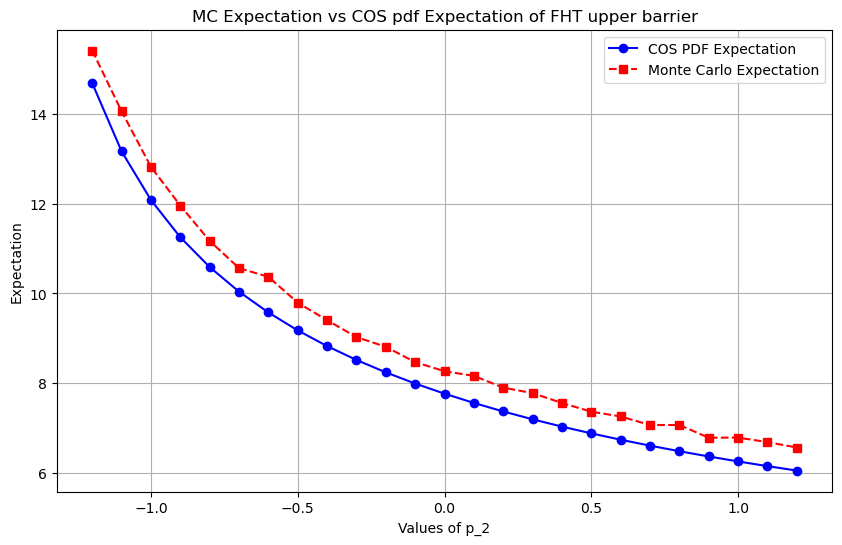

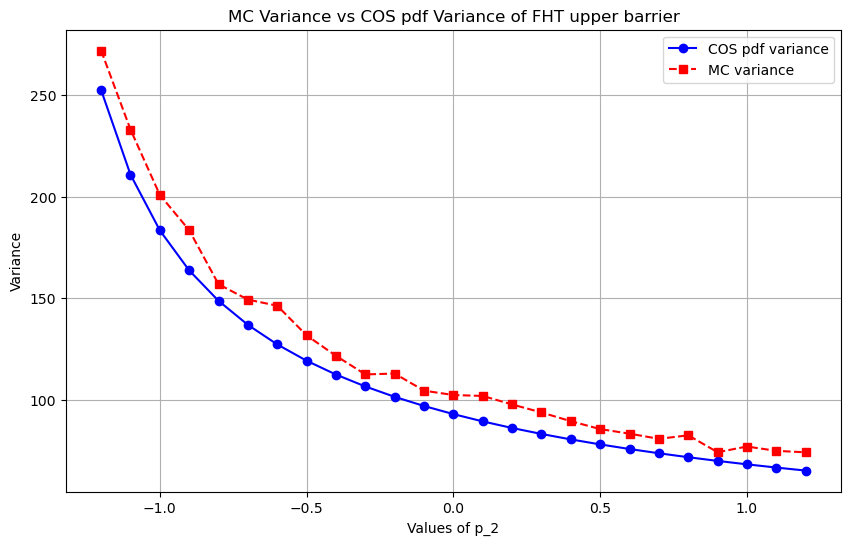

In [8]:
# testing positive and negative values of p_2 for expectation and variance for upper barrier



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = 1  # Initial value, will be changed
p_2 = -0.5
p_3 = 0.5
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used
"""
b = 8.
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p2):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / p_1
    elif degree == 2:
        return 0.5 * (p_1/current_p2) + np.sqrt((x/current_p2) + 0.25*(p_1**2/current_p2) - p_0)
    elif degree == 3:
        p = -(current_p2/(3*p_3))
        q = p**3 + (current_p2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p2, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - inv_poly(a, degree, current_p2)) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*(inv_poly(a, degree, current_p2) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def expectation_variance():
    p_2_values = np.arange(-1.2, 1.3, 0.1)
    expectation = []
    variance = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_2_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        expect = np.trapz(x*f_X, x)
        expectation.append(expect)
        E_x2 = np.trapz(x**2*f_X, x)
        var = E_x2 - expect**2
        variance.append(var)
        

    return p_2_values, expectation, variance

p_2_values, COS_expectation, COS_variance =expectation_variance()
print(p_2_values)
print(COS_expectation)
print(COS_variance)
    


T = 150                                # simulation length
m = 15000                                 # number of timepoints
time_points = np.linspace(0, T, m + 1)  # time grid

def inv_poly(x,degree):
    if degree == 1:
        inv = (x- p_0) / p_1
    elif degree == 2:
        inv = 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        inv = p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))
    return inv


def simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths,p_0, p_1, p_2, p_3):
    dt = T / m

    #initialize paths
    OU_paths = np.zeros((n_paths, m + 1))
    POLY_OU_paths = np.zeros((n_paths, m + 1))
    OU_paths[:,0] = x_0
    POLY_OU_paths[:, 0] =  p_0 + p_1 * x_0 + p_2 * x_0**2 + p_3 * x_0**3

    # Generate all random shocks upfront (size: n_paths × m)
    dW = np.sqrt(dt) * np.random.normal(0, 1, size=(n_paths, m))
    
    for j in range(m):
        OU_next = OU_paths[:, j] + theta * (mu - OU_paths[:, j]) * dt + sigma * dW[:, j]
        OU_paths[:, j + 1] = OU_next
        POLY_OU_paths[:, j + 1] = p_0 + p_1 * OU_next + p_2 * OU_next**2 + p_3 * OU_next**3
    
    return POLY_OU_paths, OU_paths 


# Simulate multiple paths
n_paths = 20000


poly_ou_paths, ou_paths = simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths, p_0, p_1, p_2, p_3)

def compute_first_hitting_times(paths, b, n_paths):
    hitting_times = []
    
    for i in range(n_paths):
        hit_index = []
        for j in range (m):
            if paths[i, j] >= a:
                hit_index.append((j/m)*T)
        if len(hit_index) > 0:
            hitting_times.append(hit_index[0])  # Store first hitting time
        
    return np.array(hitting_times)

# Compute first hitting times
hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)

#computing average first hitting time
expected_value = sum(hitting_times)/ n_paths
print("Expected value of first hitting times: ", expected_value)

#computing variance of first hitting time
variance = sum((hitting_times - expected_value) ** 2) / (len(hitting_times) - 1)

print("Variance of first hitting times: ", variance)

variance = np.var(hitting_times, ddof=1)  # Using ddof=1 for sample variance
print("Variance of first hitting times:", variance)

"""
# Plot first 5 OU paths and their polynomial transforms
plt.figure(figsize=(14, 7))

for i in range(min(5, n_paths)):
    plt.plot(time_points, ou_paths[i], 'b-', alpha=0.6, label='OU Process' if i == 0 else "")
    plt.plot(time_points, poly_ou_paths[i], 'r--', alpha=0.6, label='Polynomial Process' if i == 0 else "")

plt.axhline(a, color='k', linestyle='--', label=f'Barrier at {a}')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("OU Process vs. Polynomial Transformation (First 5 Paths)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Histogram of hitting times (if any paths hit the barrier)
if len(hitting_times) > 0:
    plt.figure(figsize=(10, 5))
    plt.hist(hitting_times, bins=120, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("First Hitting Time")
    plt.ylabel("Density")
    plt.title(f"First Hitting Times for Barrier = {a}")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print("No paths hit the barrier; no histogram generated.")
"""
# Reuse these values
p_2_values = np.arange(-1.2, 1.3, 0.1)  # Skip 0 to avoid division errors
MC_expectation = []
MC_variance = []

for p2 in p_2_values:
    poly_ou_paths, ou_paths = simulate_POLY_OU_process(
        theta, mu, sigma, x_0, T, m, n_paths,
        p_0, p_1, p2, p_3
    )
    
    hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)
    
    if len(hitting_times) > 0:
        expected_value = np.mean(hitting_times)
    else:
        expected_value = np.nan  # In case no paths hit the barrier
    
    MC_expectation.append(expected_value)
    print(f"p_2 = {p2:.1f}, Empirical Expectation = {expected_value:.4f}")
    if len(hitting_times) > 0:
        variance = np.var(hitting_times, ddof=1)
    else:
        variance = np.nan  # In case no paths hit the barrier
    
    
    MC_variance.append(variance)
    print(f"p_2 = {p2:.1f}, Empirical Variance = {variance:.4f}")



plt.figure(figsize=(10, 6))
plt.plot(p_2_values, COS_expectation, 'b-o', label='COS PDF Expectation')
plt.plot(p_2_values, MC_expectation, 'r--s', label='Monte Carlo Expectation')
plt.xlabel("Values of p_2")
plt.ylabel("Expectation")
plt.title("MC Expectation vs COS pdf Expectation of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_2_values, COS_variance, 'b-o', label='COS pdf variance')
plt.plot(p_2_values, MC_variance, 'r--s', label='MC variance')
plt.xlabel("Values of p_2")
plt.ylabel("Variance")
plt.title("MC Variance vs COS pdf Variance of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()



[-1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.11022302e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00]
[6.052266027807181, 6.151508569623258, 6.256142723236027, 6.3666886862882395, 6.483740906794028, 6.607982439484231, 6.740202876820141, 6.881320964220536, 7.03241342325875, 7.1947521121245686, 7.369852582704295, 7.559538389810106, 7.766027658716174, 7.9920517148331225, 8.241020905778406, 8.517261782755417, 8.826365392875314, 9.175714609986938, 9.57531185827553, 10.039135624742237, 10.5874838068021, 11.251297403874508, 12.080846367841557, 13.16530065540698, 14.68475666497896]
[65.14443075737394, 66.632298128883, 68.2168910712061, 69.90879388801713, 71.72025620606897, 73.66554137963905, 7

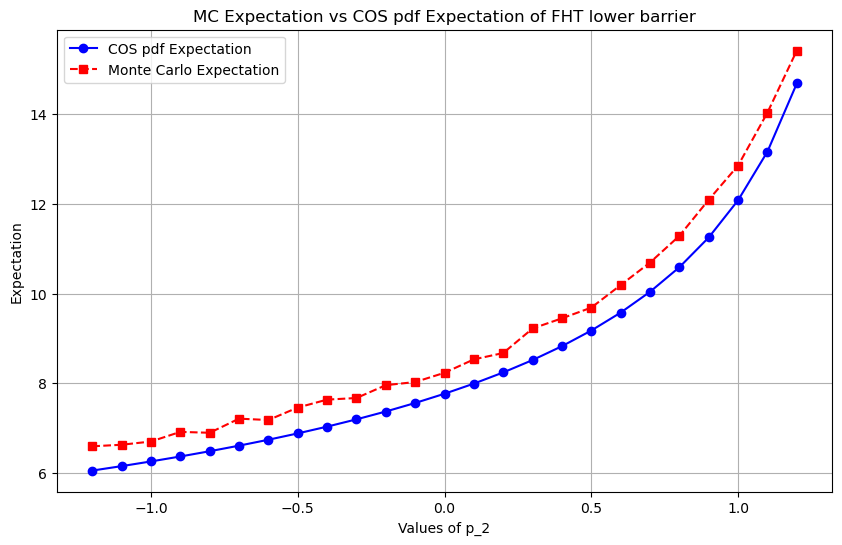

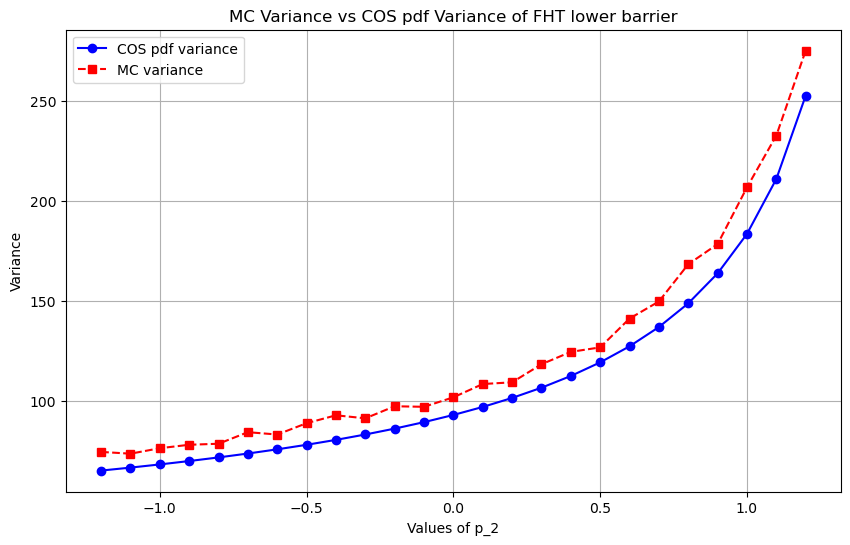

In [16]:
# testing positive and negative values of p_2 for expectation and variance for lower barrier



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = 1  # Initial value, will be changed
p_2 = -0.5
p_3 = 0.5
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used

b = 1.8
"""
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p2):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / p_1
    elif degree == 2:
        return 0.5 * (p_1/current_p2) + np.sqrt((x/current_p2) + 0.25*(p_1**2/current_p2) - p_0)
    elif degree == 3:
        p = -(current_p2/(3*p_3))
        q = p**3 + (current_p2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p2, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - (2*x_0 - inv_poly(b, degree, current_p2))) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*((2*x_0 - inv_poly(b, degree, current_p2)) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def expectation_variance():
    p_2_values = np.arange(-1.2, 1.3, 0.1)
    expectation = []
    variance = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_2_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        expect = np.trapz(x*f_X, x)
        expectation.append(expect)
        E_x2 = np.trapz(x**2*f_X, x)
        var = E_x2 - expect**2
        variance.append(var)
        

    return p_2_values, expectation, variance

p_2_values, COS_expectation, COS_variance =expectation_variance()
print(p_2_values)
print(COS_expectation)
print(COS_variance)
    


T = 150                                # simulation length
m = 15000                                 # number of timepoints
time_points = np.linspace(0, T, m + 1)  # time grid

def inv_poly(x,degree):
    if degree == 1:
        inv = (x- p_0) / p_1
    elif degree == 2:
        inv = 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        inv = p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))
    return inv


def simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths,p_0, p_1, p_2, p_3):
    dt = T / m

    #initialize paths
    OU_paths = np.zeros((n_paths, m + 1))
    POLY_OU_paths = np.zeros((n_paths, m + 1))
    OU_paths[:,0] = x_0
    POLY_OU_paths[:, 0] =  p_0 + p_1 * x_0 + p_2 * x_0**2 + p_3 * x_0**3

    # Generate all random shocks upfront (size: n_paths × m)
    dW = np.sqrt(dt) * np.random.normal(0, 1, size=(n_paths, m))
    
    for j in range(m):
        OU_next = OU_paths[:, j] + theta * (mu - OU_paths[:, j]) * dt + sigma * dW[:, j]
        OU_paths[:, j + 1] = OU_next
        POLY_OU_paths[:, j + 1] = p_0 + p_1 * OU_next + p_2 * OU_next**2 + p_3 * OU_next**3
    
    return POLY_OU_paths, OU_paths 


# Simulate multiple paths
n_paths = 20000


poly_ou_paths, ou_paths = simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths, p_0, p_1, p_2, p_3)

def compute_first_hitting_times(paths, b, n_paths):
    hitting_times = []
    
    for i in range(n_paths):
        hit_index = []
        for j in range (m):
            if paths[i, j] <= b:
                hit_index.append((j/m)*T)
        if len(hit_index) > 0:
            hitting_times.append(hit_index[0])  # Store first hitting time
        
    return np.array(hitting_times)

# Compute first hitting times
hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)

#computing average first hitting time
expected_value = sum(hitting_times)/ n_paths
print("Expected value of first hitting times: ", expected_value)

#computing variance of first hitting time
variance = sum((hitting_times - expected_value) ** 2) / (len(hitting_times) - 1)

print("Variance of first hitting times: ", variance)

variance = np.var(hitting_times, ddof=1)  # Using ddof=1 for sample variance
print("Variance of first hitting times:", variance)

"""
# Plot first 5 OU paths and their polynomial transforms
plt.figure(figsize=(14, 7))

for i in range(min(5, n_paths)):
    plt.plot(time_points, ou_paths[i], 'b-', alpha=0.6, label='OU Process' if i == 0 else "")
    plt.plot(time_points, poly_ou_paths[i], 'r--', alpha=0.6, label='Polynomial Process' if i == 0 else "")

plt.axhline(a, color='k', linestyle='--', label=f'Barrier at {a}')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("OU Process vs. Polynomial Transformation (First 5 Paths)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Histogram of hitting times (if any paths hit the barrier)
if len(hitting_times) > 0:
    plt.figure(figsize=(10, 5))
    plt.hist(hitting_times, bins=120, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("First Hitting Time")
    plt.ylabel("Density")
    plt.title(f"First Hitting Times for Barrier = {a}")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print("No paths hit the barrier; no histogram generated.")
"""
# Reuse these values
p_2_values = np.arange(-1.2, 1.3, 0.1)  # Skip 0 to avoid division errors
MC_expectation = []
MC_variance = []

for p2 in p_2_values:
    poly_ou_paths, ou_paths = simulate_POLY_OU_process(
        theta, mu, sigma, x_0, T, m, n_paths,
        p_0, p_1, p2, p_3
    )
    
    hitting_times = compute_first_hitting_times(poly_ou_paths, b, n_paths)
    
    if len(hitting_times) > 0:
        expected_value = np.mean(hitting_times)
    else:
        expected_value = np.nan  # In case no paths hit the barrier
    
    MC_expectation.append(expected_value)
    print(f"p_2 = {p2:.1f}, Empirical Expectation = {expected_value:.4f}")
    if len(hitting_times) > 0:
        variance = np.var(hitting_times, ddof=1)
    else:
        variance = np.nan  # In case no paths hit the barrier
    
    
    MC_variance.append(variance)
    print(f"p_2 = {p2:.1f}, Empirical Variance = {variance:.4f}")



plt.figure(figsize=(10, 6))
plt.plot(p_2_values, COS_expectation, 'b-o', label='COS pdf Expectation')
plt.plot(p_2_values, MC_expectation, 'r--s', label='Monte Carlo Expectation')
plt.xlabel("Values of p_2")
plt.ylabel("Expectation")
plt.title("MC Expectation vs COS pdf Expectation of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_2_values, COS_variance, 'b-o', label='COS pdf variance')
plt.plot(p_2_values, MC_variance, 'r--s', label='MC variance')
plt.xlabel("Values of p_2")
plt.ylabel("Variance")
plt.title("MC Variance vs COS pdf Variance of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()



[-1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.11022302e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00]
[16006.81427062464, 13220.2511535796, 11253.749871427572, 9795.234850387664, 8672.184709086943, 7781.7863476004695, 7059.100953582794, 6461.1645525180265, 5958.454544780081, 5530.034736821247, 5160.656918336327, 4838.959108678921, 4556.3059651241365, 4306.0198972432245, 4082.857832482545, 3882.646915586414, 3702.025407385112, 3538.255425830617, 3389.0850556778064, 3252.645258223039, 3127.372211860873, 3011.9474681768293, 2905.251866086339, 2806.3292010404293, 2714.3578422230057]
[937983.0844451194, 735431.73469622, 599196.8383599804, 502266.165397106, 430300.89070226526, 375060.0804228

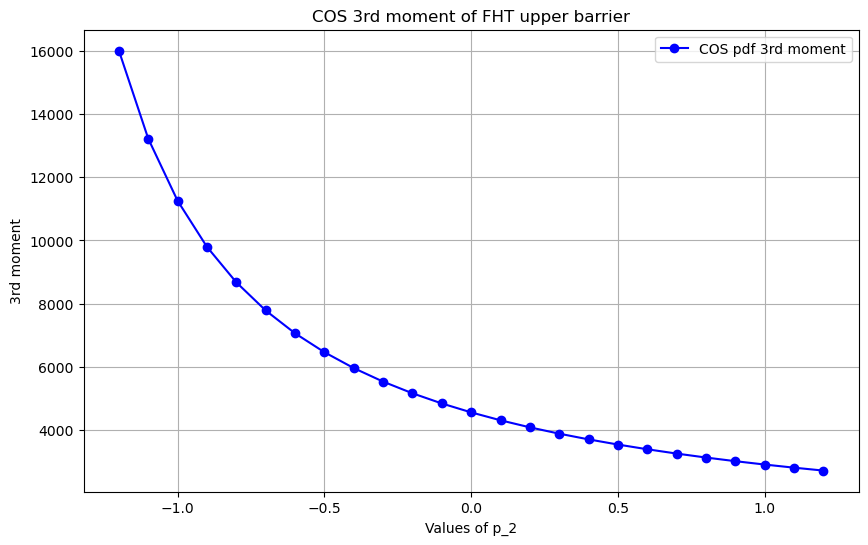

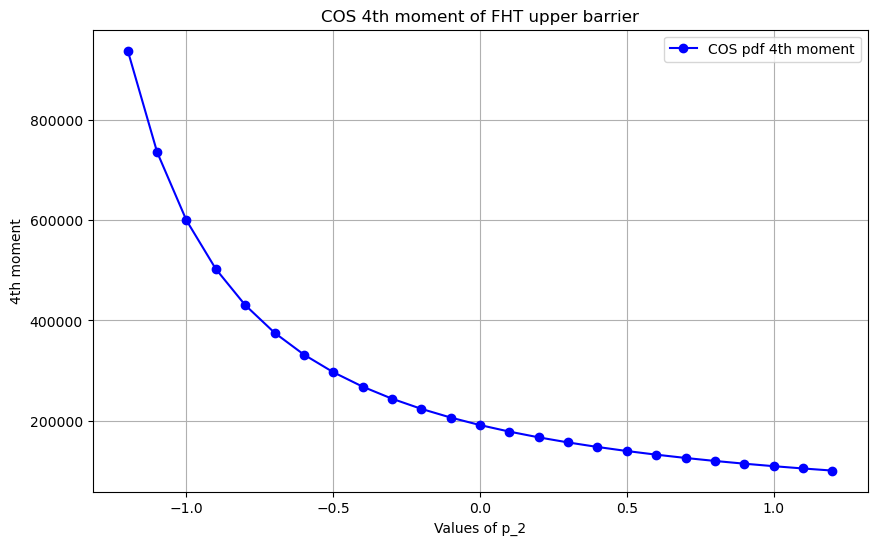

In [18]:
# testing positive and negative values of p_2 for third, fourth moment for upper barrier


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = 1  # Initial value, will be changed
p_2 = -0.5
p_3 = 1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used
"""
b = 8.
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p2):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / p_1
    elif degree == 2:
        return 0.5 * (p_1/current_p2) + np.sqrt((x/current_p2) + 0.25*(p_1**2/current_p2) - p_0)
    elif degree == 3:
        p = -(current_p2/(3*p_3))
        q = p**3 + (current_p2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p2, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - inv_poly(a, degree, current_p2)) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*(inv_poly(a, degree, current_p2) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def moment3_moment4():
    p_2_values = np.arange(-1.2, 1.3, 0.1)
    moments3 = []
    moments4 = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_2_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        moment3 = np.trapz(x**3*f_X, x)
        moments3.append(moment3)
        moment4 = np.trapz(x**4*f_X, x)
        moments4.append(moment4)
        

    return p_2_values, moments3, moments4

p_2_values, COS_moments3, COS_moments4 = moment3_moment4()
print(p_2_values)
print(COS_moments3)
print(COS_moments4)
    


plt.figure(figsize=(10, 6))
plt.plot(p_2_values, COS_moments3, 'b-o', label='COS pdf 3rd moment')
plt.xlabel("Values of p_2")
plt.ylabel("3rd moment")
plt.title("COS 3rd moment of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_2_values, COS_moments4, 'b-o', label='COS pdf 4th moment')
plt.xlabel("Values of p_2")
plt.ylabel("4th moment")
plt.title("COS 4th moment of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()



[-1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.11022302e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00]
[2714.3578422230057, 2806.3292010404293, 2905.251866086339, 3011.9474681768293, 3127.372211860873, 3252.645258223039, 3389.0850556778064, 3538.255425830617, 3702.0254073849037, 3882.646915586414, 4082.857832482545, 4306.0198972432245, 4556.3059651241365, 4838.959108678921, 5160.656918336327, 5530.034736821247, 5958.454544780081, 6461.1645525180265, 7059.100953582794, 7781.7863476004695, 8672.184709086943, 9795.234850387664, 11253.749871427572, 13220.2511535796, 16006.81427062464]
[100126.6896946111, 104342.48425334116, 108918.40658989167, 113901.03203143472, 119345.1489261371, 125315.5

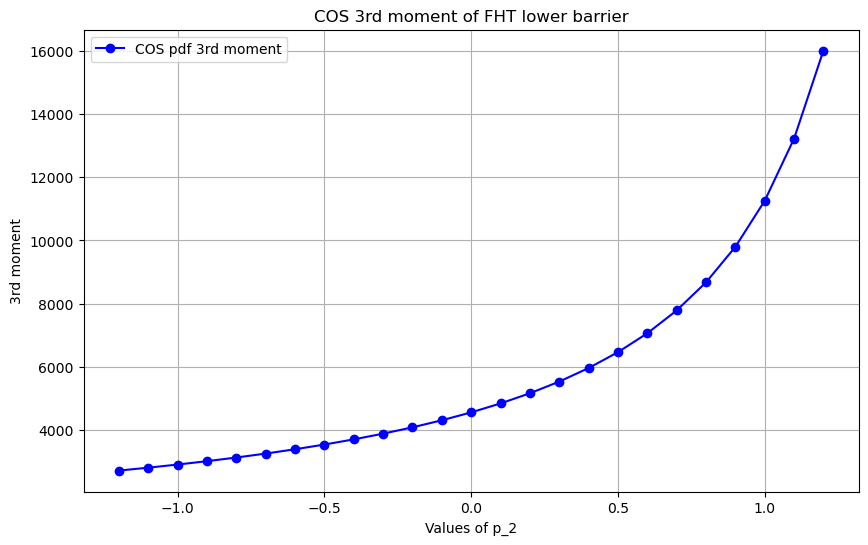

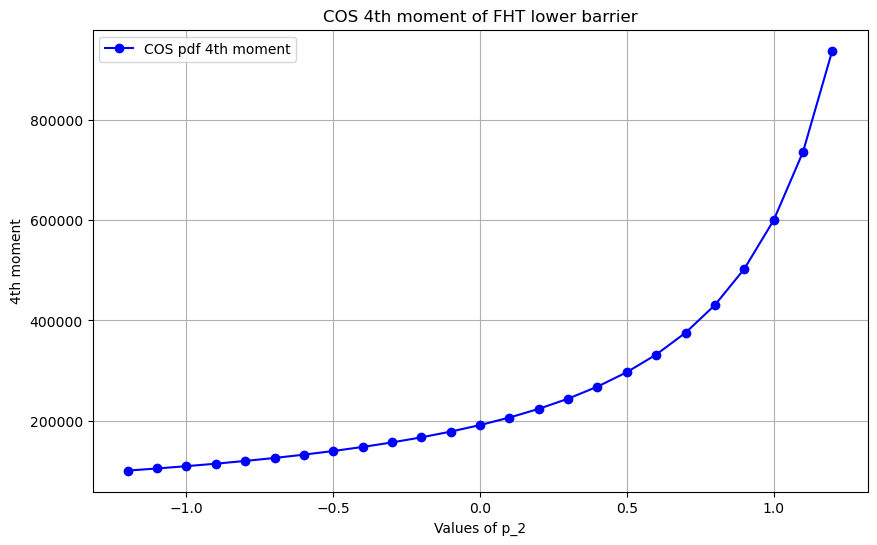

In [20]:
# testing positive and negative values of p_2 for third, fourth moment for lower barrier


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = 1  # Initial value, will be changed
p_2 = -0.5
p_3 = 1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used

b = 1.8
"""
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p2):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / p_1
    elif degree == 2:
        return 0.5 * (p_1/current_p2) + np.sqrt((x/current_p2) + 0.25*(p_1**2/current_p2) - p_0)
    elif degree == 3:
        p = -(current_p2/(3*p_3))
        q = p**3 + (current_p2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p2, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - (2*x_0 -inv_poly(b, degree, current_p2))) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*((2*x_0 - inv_poly(b, degree, current_p2)) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def moment3_moment4():
    p_2_values = np.arange(-1.2, 1.3, 0.1)
    moments3 = []
    moments4 = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_2_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        moment3 = np.trapz(x**3*f_X, x)
        moments3.append(moment3)
        moment4 = np.trapz(x**4*f_X, x)
        moments4.append(moment4)
        

    return p_2_values, moments3, moments4

p_2_values, COS_moments3, COS_moments4 = moment3_moment4()
print(p_2_values)
print(COS_moments3)
print(COS_moments4)
    


plt.figure(figsize=(10, 6))
plt.plot(p_2_values, COS_moments3, 'b-o', label='COS pdf 3rd moment')
plt.xlabel("Values of p_2")
plt.ylabel("3rd moment")
plt.title("COS 3rd moment of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_2_values, COS_moments4, 'b-o', label='COS pdf 4th moment')
plt.xlabel("Values of p_2")
plt.ylabel("4th moment")
plt.title("COS 4th moment of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

